Data Framework Project

Mael Depreville & Louis Duvanel -  GRP01 Data & AI

1 -  First step is to call the necessary libraries 

In [10]:
import glob
import os
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import streamlit as st
import matplotlib.dates as mdates

from datetime import timedelta

from pyspark.sql.functions import avg, month, year, day, lit
from pyspark.sql import SparkSession
import pyspark.pandas as ps
from pyspark.sql import DataFrame
from pyspark.sql.functions import avg, month, year,lit
from pyspark.sql import functions as F

from script.DataFrame import DataframeClass


2 - Then, we load our datasets for future analysis

In [ ]:
spark = SparkSession.builder.appName("StockVariation").getOrCreate()

dataframe_obj = DataframeClass()

csv_folder_path = 'Stocks_Price'
csv_files = glob.glob(os.path.join(csv_folder_path, "*.csv"))

data_dfs = dataframe_obj.read_multiple_csv(csv_files)

3 - We import business analysis functions, among them : 

In [12]:
def period_to_day(string : str):
    if string == "w" :
        return 7
    elif string == "m":
        return 30
    elif string == "y":
        return 365

    else : 
        print("[INFO] -> Mistake in the given string ")
        return -1

# Input : period -> w for weekly, y for yearly, m for monthly 
# str -> Open ou Close
# Output : DataFrame (Period, Average_STR_Price($))
# Plot associé : Linear Chart
 
def avg_price(df : DataFrame, period : str, str : str):

    trigger = False
  
    if str in ["Open", "Close"] and period in ["w", "m", "y"]:
        
        nb_samples = period_to_day(period)
        
        initDate = df.select("Date").first()[0]
        
        tmp = []
        dictio = {}

        for row in df.collect():
            
            diff = row.Date - initDate
            
            if abs(diff.days) < nb_samples :
                tmp.append(getattr(row, str))
            else :
                trigger = True
                dictio[row.Date] = np.round(np.average(tmp), 3)
                tmp = []
                initDate = row.Date

        if trigger == False :
            print("[INFO] -> Dataset too small to analyze for the given period")
            return -1
        
        ps_df = ps.DataFrame(list(dictio.items()), columns=["Period", f"Average_{str}_Price($)"])

        return ps_df
    else : 
        print("[INFO] -> Error in one of the parameters, please give (period : w, y, m and existing column for str)")
        return -1

# Fonction utile pour labelisation des mois

def get_month_name(month_number : int, year):
    months = [
        "", 
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sept",
        "Oct",
        "Nov",
        "Dec"
    ]
    
    if 1 <= month_number <= 12:
        return months[month_number] + "-"+ str(year)
    else : 
        return -1

# Mesure variation day to day selon la colonne donnée : str
# Variation : CLOSE PRICE - OPEN PRICE
# Return a pyspark dataframe
# Plot associé : Linear Chart 

def dtd_stock_variation(df : DataFrame):
    
    df = df.withColumn("Stock_Variation", lit(0))
    p_df = df.toPandas()

    for pos, row in enumerate(p_df):
       
        i = pos + 1 # pos prend en compte l'entete

        if i <= len(p_df) :
            p_df["Stock_Variation"] = np.round((p_df["Close"] - p_df["Open"]), 3)
  
    ps_df = ps.DataFrame(p_df)

    return ps_df
        
# Mesure des variations pour chaque mois d'une colonne donnée
# str : "Volume", "Open", "Close"
# Variation : DERNIER JOUR DU MOIS CLOS - PREMIER JOUR DU MOIS OPEN
# Return: pyspark.pandas dataframe
# Plot associé : Linear Chart

def monthly_stock_variation(df : DataFrame, nb_of_month : int = None):
    

    init_date = df.select("Date").first()[0]
    init_str = df.select("Open").first()[0]

    stock = {}

    counter = 0

    for pos, row in enumerate(df.collect()):
        
        diff = row.Date - init_date

        if abs(diff) >= timedelta(days = 30) :
            
            counter += 1
            val_beg = init_str

            val_fin = getattr(row, "Close")

            stock[row.Date] = np.round(val_fin - val_beg, 3)

            if counter == nb_of_month :
                break

            init_date= row.Date
            init_str = getattr(row, "Open")

        if pos+1 == len(df.collect()):

                val_beg = init_str
                val_fin = getattr(row, "Close")

                stock[row.Date] = np.round(val_fin - val_beg, 3)
    

    p_df = pd.DataFrame(list(stock.items()), columns=["Period", f"Stock_Variation_($)"])
    ps_df = ps.DataFrame(p_df)
    
    return ps_df

# Mesure le benefice max sur d'un DF
#Retourn un dataframe pandasOnSpark

def max_daily_return(df : DataFrame):
    ps_df = dtd_stock_variation(df)
    s_df = ps_df.to_spark()
    s_df = s_df.select(F.max("Stock_Variation").alias("Maximum_profit"))
    ps_df = ps.DataFrame(s_df)
    return ps_df

# Determine la moyenne des rentabilites des actions sur une période donnée (rentabilité : close-open)
# period : w pour week, m pour month, y pour year
# Return un dataframe pandaOnSpark
# Plot associé : Linear Chart

def avg_return(df : DataFrame, period : str):

    if period in ["w", "m", "y"]:

        df = df.sort("Date", ascending = True)
        trigger = False
    
        tmp_df = dtd_stock_variation(df)
        tmp_df = tmp_df.to_spark()

        nb_sample = period_to_day(period)
        init_date = tmp_df.select("Date").first()[0]
        stock_var = {}
        tmp_array = []
    
        for row in tmp_df.collect():
            diff = init_date - row.Date
            if abs(diff.days) < nb_sample:
                tmp_array.append(row.Stock_Variation)
            else :
                trigger = True
                key = f"{init_date} to {row.Date}"
                stock_var[key] = np.round(np.average(np.array(tmp_array)), 3)
                init_date = row.Date
                tmp_array = []

        if trigger == False :
            print("[INFO] Given period too large for the dataset")
            return -1
        
        col_name1 = "Period"
        col_name2 = "Average_Stock_Variation_($)"
        p_df = pd.DataFrame(list(stock_var.items()), columns=[col_name1, col_name2])
        ps_df = ps.DataFrame(p_df)
        
        return ps_df
    else :
        return -1

# Input : df, colonne à examiner (Open, Close, etc), nombre de données à moyenner
# Output : Data 

def moving_average(df : DataFrame, given_col : str, nb_sample : int):
    
    df = df.sort("Date", ascending = False)
    
    tmp_array = []

    for pos, row in enumerate(df.collect()):
        
        if pos + 1 <= nb_sample:
            tmp_array.append(getattr(row, given_col))
        else :
            break
    
    moving_average = np.round(np.average(tmp_array), 3)

    p_df = df.toPandas()
    p_df["Moving_Average"] = moving_average
    
    ps_df = ps.DataFrame(p_df.head(nb_sample)) # Retourn un df de la taille du nb de sample donnée

    return ps_df

# Input : 2 Datasets, existing columns for both of them
# Ouput : DataFrame with correlation value
# => Methode Pearson utilisée pour la corrélation
# Plot associé : Scatter Plot

def correlation_btw_stocks(df_1 : DataFrame, df_2 : DataFrame, col : str):

    pdf_1 = df_1.selectExpr("{} as D1".format(col)).toPandas()
    pdf_2 = df_2.selectExpr("{} as D2".format(col)).toPandas()

    p_df = pd.concat([pdf_1, pdf_2], axis=1)
    
    return p_df.corr(method="pearson")
 
# Input : df, period [w, m, y]
# Output : PandaOnPyspark df [Period, Return Rate]
# Return Rate : [[Close - Open]/Open] * 100
# Plot associé : Linear Chart

def return_rate(df : DataFrame, period : str):

    if period in ["w", "m", "y"]:

        nb_samples = period_to_day(period)

        init_date = df.select("Date").first()[0]
        init_open = df.select("Open").first()[0]

        dictio = {}
        trigger = False

        for row in df.collect():
            diff = row.Date - init_date
            if abs(diff) >= timedelta(days=nb_samples) :
                trigger = True
                rate = ((row.Close - init_open)/init_open) * 100
                key = f"{init_date} to {row.Date}"
                dictio[key] = rate
                init_date = row.Date
                init_open = row.Open

        if trigger == False:
            print("[INFO] -> Period too large to be used on this dataset")
            return -2 
        ps_df = ps.DataFrame(list(dictio.items()), columns=["Period", "Return_Rate_(%)"])

        return ps_df
    else :
        print("[INFO] -> can't take parameter period in charge")
        return -1

# Bénéfice Maximum sur une période donnée
# Retourne un PS DataFrame

def max_return_rate(df : DataFrame, period : str):
    ps_df = return_rate(df, period)
    s_df = ps_df.to_spark()
    return ps.DataFrame(s_df.select(F.max("Return_Rate_(%)").alias("Max_Return_Rate")))


# Input : df, nombres d'actions détenues
# Output : PS Dataframe avec col Revenus

def dividend_return(df : DataFrame, stocks_own : float):

    ps_df = ps.DataFrame(df)
    ps_df["Revenus"] = ps_df["Dividends"] * stocks_own
    return ps_df

def variation_stocks_volume(df : DataFrame, period_sample : str) :

    init_vol = df.select("Volume").first()[0]
    init_Date = df.select("Date").first()[0]

    nb_samples = period_to_day(period_sample)
    dictio = {}
 
    for pos, row in enumerate(df.collect()):
        diff = row.Date - init_Date
        if abs(diff.days) >= nb_samples or pos +1 == len(df.collect()):
            dictio[row.Date] = np.round((row.Volume - init_vol), 3)
            init_vol = row.Volume
            init_Date = row.Date
    
    p_df = pd.DataFrame(list(dictio.items()), columns=["Period", "Variation_Volume"])
    ps_df = ps.DataFrame(p_df)

    return ps_df

4 - We load the visual functions

In [22]:
def period_to_string(string) :
    if string == "w" :
        return "Weekly"
    elif string == "m":
        return "Monthly"
    elif string == "y":
        return "Yearly"

    else : 
        print("[INFO] -> Mistake in the given string ")
        return -1

# Bar Charts
# X d
def bar_plot(x, y):

    x_n = x.to_numpy()
    y_n = y.to_numpy()

    colors = ["blue" if value > 0 else "red" for value in y_n]

    plt.figure(figsize=(12, 6))
    plt.bar(x_n, y_n, color = colors, width=14)
    plt.title(f"{y.name}")
    plt.xticks(rotation=70)

    plt.xlabel("Date")
    plt.ylabel("Variation")
    plt.legend()
    plt.show()

def linear_plot(x, y, period, str = None, color_used = "blue"):
    
    x_n = x.to_numpy()
    y_n = y.to_numpy()

    fig_xshape = 14

    if len(x_n) > 90 :
        ticks_split = 12
        fig_xshape = 14
    elif 60 <= len(x_n) <= 90:
        ticks_split = 5
    elif 30 <= len(x_n) < 60 :
        ticks_split = 3
    elif 15 <= len(x_n) <=30 :
        ticks_split = 2
    else :
        ticks_split = 1

    fig, axes = plt.subplots(figsize = (fig_xshape, 6))

    axes.set_xticks(x_n[::ticks_split]) # Afficher des ticks tous les 3 mesures 

    axes.set_xticklabels([date for date in x_n[::ticks_split]])
    axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    axes.plot(x_n, y_n, marker = "o", color =  color_used, alpha = .5 )
    axes.set_xlabel(x.name)
    axes.set_ylabel(y.name)

    axes.tick_params(axis='x', rotation=50)
    axes.set_mouseover(mouseover = True)

    if str == None :
        plt.title(f"{period_to_string(period)}_Average_{str}_Price_($)")
    else :
        plt.title(f"{period_to_string(period)}_Average_Price_($)")
    plt.show()

def scatter_plot(x, y, x_name = None, y_name = None, title=None):
    plt.scatter(x, y)

    plt.title
    plt.xlabel(x_name)
    plt.ylabel(y_name)

    plt.legend()
    plt.show()

def streamlit_test(df):
    st.write(df)

In [23]:
result = variation_stocks_volume(data_dfs[5], "m")
display(result.head(5))

,Period,Variation_Volume
0,2024-09-27,-2685700.0
1,2024-08-28,-13400.0
2,2024-07-29,243100.0
3,2024-06-28,13236500.0
4,2024-05-29,-12845200.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


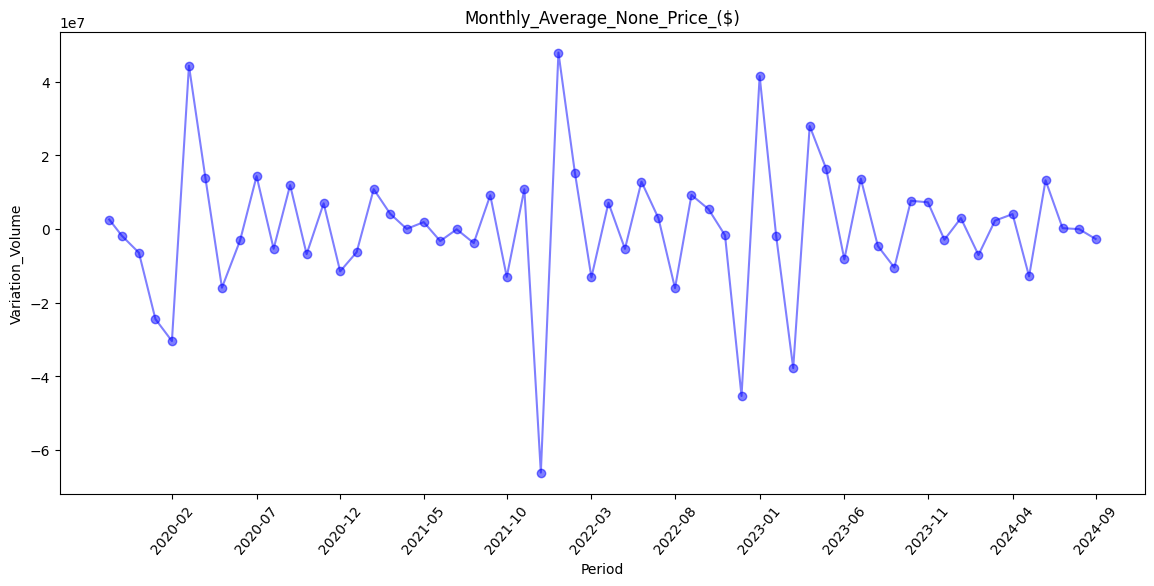

In [24]:
linear_plot(result['Period'], result['Variation_Volume'], "m")